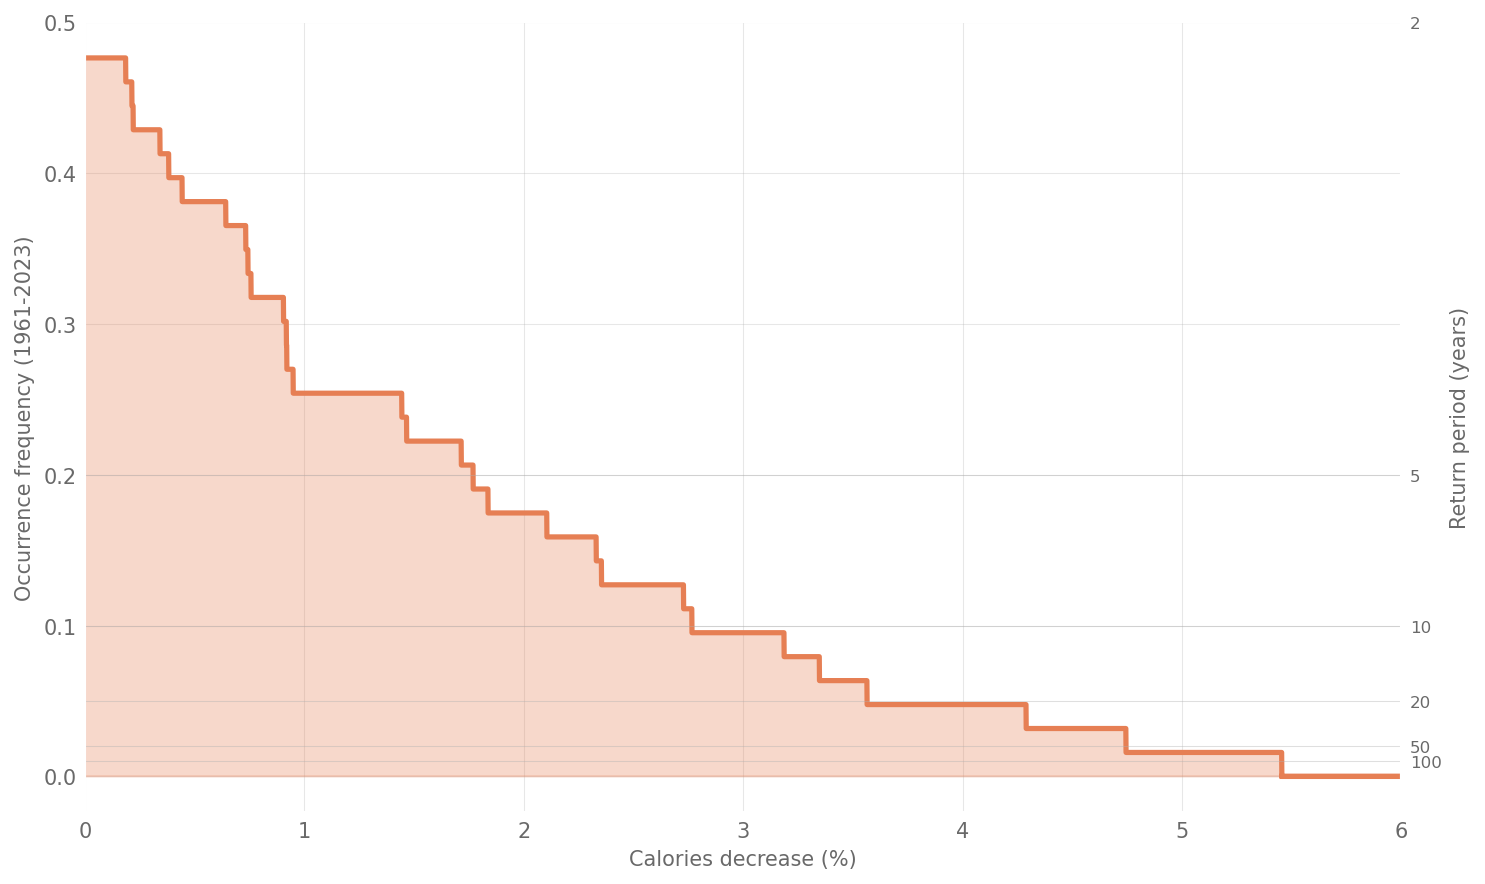

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Apply ALLFED style sheet
plt.style.use("https://raw.githubusercontent.com/allfed/ALLFED-matplotlib-style-sheet/main/ALLFED.mplstyle")

def shock_probability_vs_intensity(start_year=1961, end_year=2023, bin_width=0.001, gcff_threshold=np.nan, xmax=10):
    """
    Make a figure of the probability of a shock vs. its intensity for World data,
    with a second y-axis showing recurrence rate.
    
    Arguments:
        start_year (int): start year for the figure
        end_year (int): end year for the figure
        bin_width (float): width of bins for shock intensity
        gcff_threshold (float): threshold for Global Catastrophic Food Failure (optional)
        xmax (float): maximum value for the x-axis
    
    Returns:
        fig, ax1, ax2: matplotlib figure and both axes objects
    """
    # Read the yield changes data
    df = pd.read_csv('../results/yield_changes_by_regions.csv', index_col=0)
    
    # Extract World data as pandas Series with years as index
    world_row = df.loc['World']
    years = [int(col) for col in df.columns]
    series = pd.Series(world_row.values, index=years)
    
    # Filter for the specified year range
    series = series[(series.index >= start_year) & (series.index <= end_year)]
    
    # Create bins from 0 to maximum possible shock
    bins = np.arange(0, 100, bin_width)
    baseline = end_year - start_year + 1
    prob_plot = []
    
    for bin_val in bins:
        # Count years where there was a negative yield change (decrease)
        # AND the absolute decrease was >= bin_val
        series_bin = series[
            (series < 0) & (series <= -bin_val)
        ]
        prob = len(series_bin) / baseline
        prob_plot.append(prob)
    
    # Add a final bin to ensure the curve reaches 0
    # Find the maximum shock magnitude
    max_shock = abs(series[series < 0].min()) if len(series[series < 0]) > 0 else 0
    final_bin = max_shock + bin_width
    prob_plot.append(0.0)  # Final empty bin with 0 probability
    bins = np.append(bins, final_bin)
    
    # Create the plot with the first y-axis
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot the occurrence frequency curve with filled area on first axis
    ax1.plot(bins, prob_plot, color='#e67f54', linewidth=2.5)
    ax1.fill_between(bins, prob_plot, alpha=0.3, color='#e67f54')
    
    # Set labels for first axis (no color)
    ax1.set_xlabel("Calories decrease (%)")
    ax1.set_ylabel(f"Occurrence frequency ({start_year}-{end_year})")
    
    # Create second y-axis for recurrence rate
    ax2 = ax1.twinx()
    
    # For the second axis, we need to create a non-linear scale
    # that shows recurrence rate = 1/frequency
    
    # Get the current y-limits from the first axis
    y1_min, y1_max = ax1.get_ylim()
    
    # Define meaningful recurrence periods to show on the second axis
    recurrence_periods = [2, 5, 10, 20, 50, 100]
    
    # Calculate corresponding frequencies for these recurrence periods
    freq_for_recurrence = [1.0 / period for period in recurrence_periods]
    
    # Filter to only include recurrence periods within our frequency range
    # Also exclude very high frequencies (low recurrence) if they're above our max
    valid_ticks = []
    valid_labels = []
    for period, freq in zip(recurrence_periods, freq_for_recurrence):
        if freq <= y1_max and freq >= max(y1_min, 0.001):  # Avoid near-zero frequencies
            valid_ticks.append(freq)
            valid_labels.append(str(period))
    
    # Set the second axis to have the same scale as the first
    ax2.set_ylim(ax1.get_ylim())
    
    # Set custom tick positions and labels for the second axis
    ax2.set_yticks(valid_ticks)
    ax2.set_yticklabels(valid_labels, fontsize=8)
    
    # Set label for second axis (no color)
    ax2.set_ylabel("Return period (years)")
    
    # Handle the GCFF threshold if provided
    if not np.isnan(gcff_threshold):
        # Set axis limits
        ax1.set_xlim(0, gcff_threshold + 1)
        ymax1 = ax1.get_ylim()[1]
        
        # Add vertical line for GCFF threshold
        ax1.axvline(x=gcff_threshold, linestyle="--", color='gray', alpha=0.7)
        ax1.text(gcff_threshold * 0.999, ymax1 / 1.5, "GCF threshold", 
                ha="right", va="center", rotation=90, color='gray')
    else:
        # Set axis limits
        ax1.set_xlim(0, xmax)
    
    # Add grid for better readability (only from first axis to avoid double grid)
    ax1.grid(True, alpha=0.3)
    
    # Ensure tight layout
    plt.tight_layout()
    
    return fig, ax1, ax2


if __name__ == "__main__":
    # Create the plot matching the original figure with dual y-axes
    fig, ax1, ax2 = shock_probability_vs_intensity(xmax=6)
    
    plt.show()